# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') 

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn. metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import tree
from tqdm import tqdm

In [2]:
df=pd.read_csv('/datasets/users_behavior.csv')

In [3]:
display(df.head(10))

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Не вижу каких то проблем с данными, за исключением, что тип для звонков и сообщений можно поменять на целочисленный

In [6]:
df.astype({ "calls": "int64", "messages": "int64"})

,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0
...,...,...,...,...,...
3209,122,910.98,20,35124.90,1
3210,25,190.36,0,3275.61,0
3211,97,634.44,70,13974.06,0
3212,64,462.32,90,31239.78,0


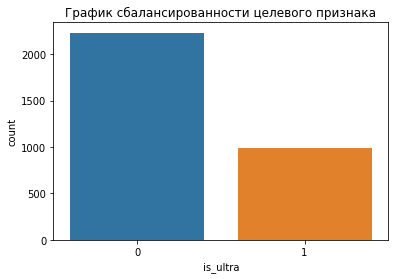

(985, 5)
(2229, 5)


In [7]:
sns.countplot(df["is_ultra"])
plt.title("График сбалансированности целевого признака")
plt.show() 

is_ultra= df [df ["is_ultra"]==1] 
is_smart=df[df["is_ultra"]==0]
print(is_ultra.shape) 
print(is_smart.shape)

             calls   minutes  messages   mb_used  is_ultra
calls     1.000000  0.982083  0.177385  0.286442  0.207122
minutes   0.982083  1.000000  0.173110  0.280967  0.206955
messages  0.177385  0.173110  1.000000  0.195721  0.203830
mb_used   0.286442  0.280967  0.195721  1.000000  0.198568
is_ultra  0.207122  0.206955  0.203830  0.198568  1.000000


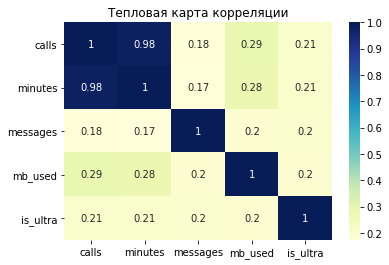

In [8]:
print(df.corr())
df_plot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.title('Тепловая карта корреляции')
plt.show()

Два признака сильно коррелированы "calls" и "minutes", присутствует мультиколлинеарность между ними в датасете. 

## Разбейте данные на выборки

In [9]:
features = df.drop(["is_ultra"], axis=1) # извлекаем признаки 
target = df["is_ultra"] # извлекаем целевой признак


Разделим датасет на 3 выборки (обучающую 60%, валидационную 20%, тестовую 20%)

Обучающая выборка (на которой модель обучают)

Валидационная выборка (для оценки переобученности модели, для оценки ошибки прогнозирования при выборе модели, для настройки гиперпараметров и выбора лучшей модели), показывает, как может повести себя модель с новыми данными.
При валидации модели выбирают набор гиперпараметров, который соответствует лучшей модели.

Тестовая выборка (для оценки работы готовой модели, для оценки ошибки обобщения для окончательной выбранной модели)

In [10]:
#делим исходный датасет на обучающую и тестовую выборки в соотнощении 0.8/0.2
features_train, features_test, target_train, target_test = \
        train_test_split(features,target,train_size=0.8,random_state=12345, stratify=target)

#от обучающей выборки отделяем валидационную выборку в соотношении 0.25
features_train, features_valid, target_train, target_valid = \
        train_test_split(features_train,target_train,train_size=0.75,random_state=12345,stratify=target_train)


In [11]:
display("Размер обучающей выборки")
display(features_train.shape)
display(target_train.shape)
display("Размер валидационной выборки")
display(features_valid.shape)
display(target_valid.shape)
display("Размер тестовой выборки")
display(features_test.shape)
display(target_test.shape)

'Размер обучающей выборки'

(1928, 4)

(1928,)

'Размер валидационной выборки'

(643, 4)

(643,)

'Размер тестовой выборки'

(643, 4)

(643,)

Для равномерного распределения количества классов в наборах данных, разделенных для обучения, насройки и тестирования добавил стратификацию по таргетам.

## Исследуйте модели

### DecisionTreeClassifier

На начальном этапе исследования дерева решений на валидационной выборке посмотрел, как на точность модели влияет гиперпараметр глубина дерева при значении всех остальных гиперпараметров "по умолчанию". Обработку организовал с помощью цикла, увеличивая на каждой итерации глубину дерева. 

In [12]:
%%time
best_model_dtc = None
best_result_dtc = 0

train_acc = []#список метрик accuracy на тренировке
valid_acc = []#список метрик accuracy на валидации

for depth in range(1, 31):
    model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=depth,\
            max_features=None, max_leaf_nodes=None,\
            min_impurity_decrease=0.0, min_impurity_split=None,\
            min_samples_leaf=1, min_samples_split=2,\
            min_weight_fraction_leaf=0.0,random_state=12345,\
            splitter='best')
    # обучиv модель с заданной глубиной дерева
    model.fit(features_train,target_train) # обучаем модель
    train_acc.append(model.score(features_train, target_train))#собираем метрику accuracy в список на тренировке     
    predictions = model.predict(features_valid) # получаем предсказания модели    
    result = accuracy_score(target_valid, predictions) # считаем качество модели
    valid_acc.append(result) #собираем метрику accuracy в список на валидации
    if result > best_result_dtc: #находим лучший результат
        best_model_dtc = model
        best_depth_dtc = depth
        best_result_dtc = result
    print(f"max_depth = {depth} :", best_result_dtc)

print("Accuracy лучшей модели:", best_result_dtc)
print("Depth лучшей модели:", best_depth_dtc)

#print(train_acc)
#print(valid_acc)



max_depth = 1 : 0.7589424572317263
max_depth = 2 : 0.7838258164852255
max_depth = 3 : 0.8040435458786936
max_depth = 4 : 0.8040435458786936
max_depth = 5 : 0.8164852255054432
max_depth = 6 : 0.8164852255054432
max_depth = 7 : 0.8164852255054432
max_depth = 8 : 0.8164852255054432
max_depth = 9 : 0.8164852255054432
max_depth = 10 : 0.8164852255054432
max_depth = 11 : 0.8164852255054432
max_depth = 12 : 0.8164852255054432
max_depth = 13 : 0.8164852255054432
max_depth = 14 : 0.8164852255054432
max_depth = 15 : 0.8164852255054432
max_depth = 16 : 0.8164852255054432
max_depth = 17 : 0.8164852255054432
max_depth = 18 : 0.8164852255054432
max_depth = 19 : 0.8164852255054432
max_depth = 20 : 0.8164852255054432
max_depth = 21 : 0.8164852255054432
max_depth = 22 : 0.8164852255054432
max_depth = 23 : 0.8164852255054432
max_depth = 24 : 0.8164852255054432
max_depth = 25 : 0.8164852255054432
max_depth = 26 : 0.8164852255054432
max_depth = 27 : 0.8164852255054432
max_depth = 28 : 0.8164852255054432
m

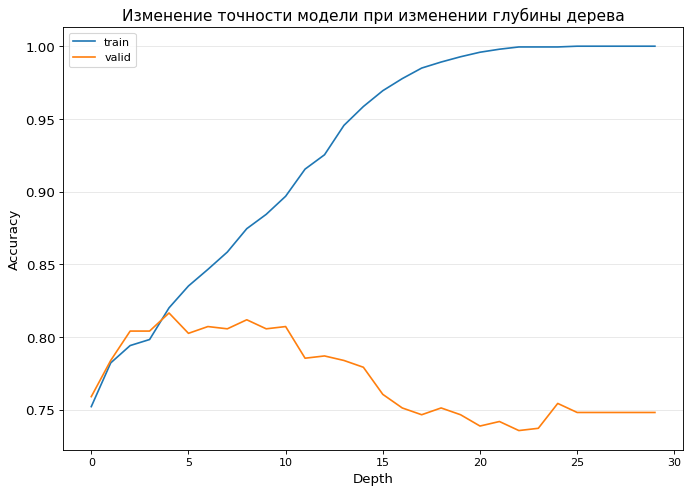

In [13]:
plt.figure(figsize=(10,7), dpi=80)
plt.ylabel('Accuracy',fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Depth',fontsize=12)
plt.yticks(fontsize=12)
plt.title("Изменение точности модели при изменении глубины дерева", fontsize=14)
plt.grid(axis='y', alpha=.3)
plt.plot(train_acc, label='train');
plt.plot(valid_acc, label='valid');
plt.legend(loc='best');

В результате самая лучшая точность модели получилась у 5ти уровнего дерева при значениие всех остальных гиперпараметров "по умолчанию". После 5го уровня модель "переобучается" и теряет точность на валидационной выборке. На тренировочной выборке модель так же "переобучается" и ее точность в конечном итоге достигает 1. 

Построим tree_plot, чтобы обьяснить заказчику как примерно модель принимает решение.

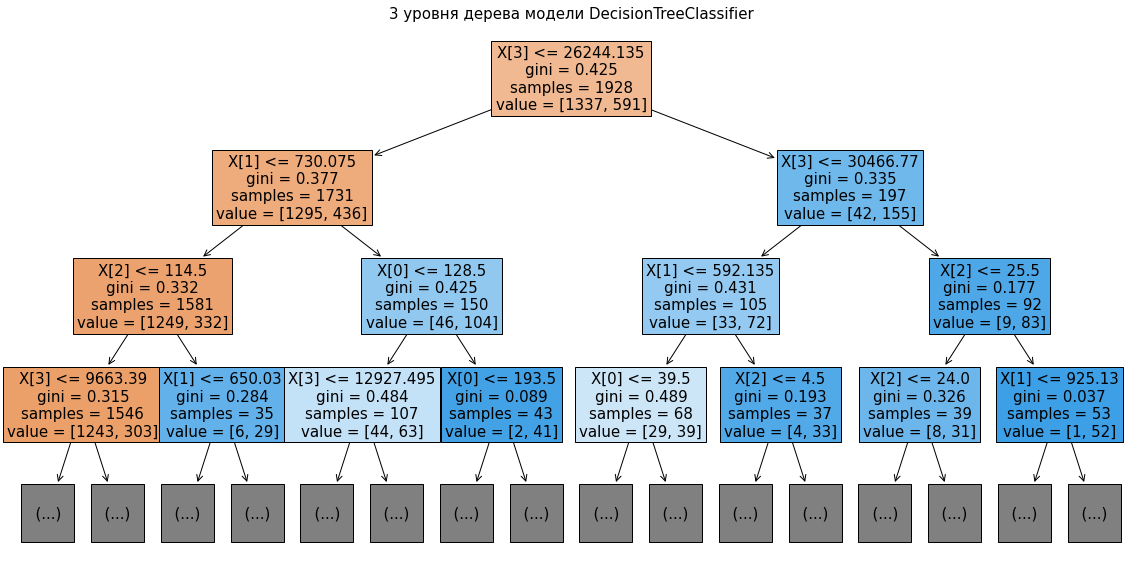

In [14]:
fig, axe = plt.subplots(figsize=(20,10))
tree.plot_tree(model,max_depth=3, filled=True,ax = axe, fontsize=15);
plt.title('3 уровня дерева модели DecisionTreeClassifier',fontsize=15);


### RandomForestClassifier

На начальном этапе исследования модели случайного дерева решений на валидационной выборке посмотрел, как на точность модели влияет гиперпараметр количество деревьев при значении всех остальных гиперпараметров "по умолчанию". Обработку организовал с помощью цикла, увеличивая на каждой итерации количество деревьев.

In [15]:
best_model_rfc = None
best_result_rfc = 0

for est in tqdm(range(1, 16)):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est,max_depth=depth) # обучим модель с заданным количеством деревьев
        model.fit(features_train,target_train) # обучим модель на тренировочной выборке
        result = model.score(features_valid,target_valid) # посчитаем качество модели на валидационной выборке
        if result > best_result_rfc:
            best_model_rfc = model# сохраняем наилучшую модель
            best_result_rfc = result#  сохраняем наилучшее значение метрики accuracy на валидационных данных
            best_n_estimators = est#  сохраняем наилучшее значение гиперпараметра n_estimators на валидационных данных
            best_max_depth = depth#  сохраняем наилучшее значение гиперпараметра depth на валидационных данных
        print(f"max_n_estimators = {est} :", best_n_estimators)
        print(f"max_depth = {depth} :", best_max_depth)
print()
print("Accuracy наилучшей модели на валидационной выборке:", best_result_rfc)
print("Лучшее количество деревьев:",best_n_estimators )
print("Лучшая глубина дерева:",best_max_depth )



 13%|█▎        | 2/15 [00:00<00:01, 10.55it/s]

max_n_estimators = 1 : 1
max_depth = 1 : 1
max_n_estimators = 1 : 1
max_depth = 2 : 2
max_n_estimators = 1 : 1
max_depth = 3 : 2
max_n_estimators = 1 : 1
max_depth = 4 : 2
max_n_estimators = 1 : 1
max_depth = 5 : 5
max_n_estimators = 1 : 1
max_depth = 6 : 5
max_n_estimators = 1 : 1
max_depth = 7 : 5
max_n_estimators = 1 : 1
max_depth = 8 : 5
max_n_estimators = 1 : 1
max_depth = 9 : 5
max_n_estimators = 1 : 1
max_depth = 10 : 5
max_n_estimators = 2 : 1
max_depth = 1 : 5
max_n_estimators = 2 : 1
max_depth = 2 : 5
max_n_estimators = 2 : 1
max_depth = 3 : 5
max_n_estimators = 2 : 1
max_depth = 4 : 5
max_n_estimators = 2 : 1
max_depth = 5 : 5
max_n_estimators = 2 : 1
max_depth = 6 : 5
max_n_estimators = 2 : 2
max_depth = 7 : 7
max_n_estimators = 2 : 2
max_depth = 8 : 8
max_n_estimators = 2 : 2
max_depth = 9 : 8
max_n_estimators = 2 : 2
max_depth = 10 : 8
max_n_estimators = 3 : 2
max_depth = 1 : 8
max_n_estimators = 3 : 2
max_depth = 2 : 8
max_n_estimators = 3 : 2
max_depth = 3 : 8
max_n_est

 27%|██▋       | 4/15 [00:00<00:01,  7.70it/s]

max_n_estimators = 4 : 4
max_depth = 7 : 7
max_n_estimators = 4 : 4
max_depth = 8 : 7
max_n_estimators = 4 : 4
max_depth = 9 : 7
max_n_estimators = 4 : 4
max_depth = 10 : 7
max_n_estimators = 5 : 4
max_depth = 1 : 7
max_n_estimators = 5 : 4
max_depth = 2 : 7
max_n_estimators = 5 : 4
max_depth = 3 : 7
max_n_estimators = 5 : 4
max_depth = 4 : 7
max_n_estimators = 5 : 5
max_depth = 5 : 5
max_n_estimators = 5 : 5
max_depth = 6 : 5
max_n_estimators = 5 : 5
max_depth = 7 : 5


 33%|███▎      | 5/15 [00:00<00:01,  6.70it/s]

max_n_estimators = 5 : 5
max_depth = 8 : 8
max_n_estimators = 5 : 5
max_depth = 9 : 8
max_n_estimators = 5 : 5
max_depth = 10 : 8
max_n_estimators = 6 : 5
max_depth = 1 : 8
max_n_estimators = 6 : 5
max_depth = 2 : 8
max_n_estimators = 6 : 5
max_depth = 3 : 8
max_n_estimators = 6 : 5
max_depth = 4 : 8
max_n_estimators = 6 : 5
max_depth = 5 : 8
max_n_estimators = 6 : 5
max_depth = 6 : 8
max_n_estimators = 6 : 5
max_depth = 7 : 8


 40%|████      | 6/15 [00:00<00:01,  5.80it/s]

max_n_estimators = 6 : 6
max_depth = 8 : 8
max_n_estimators = 6 : 6
max_depth = 9 : 8
max_n_estimators = 6 : 6
max_depth = 10 : 8
max_n_estimators = 7 : 6
max_depth = 1 : 8
max_n_estimators = 7 : 6
max_depth = 2 : 8
max_n_estimators = 7 : 6
max_depth = 3 : 8
max_n_estimators = 7 : 6
max_depth = 4 : 8
max_n_estimators = 7 : 6
max_depth = 5 : 8
max_n_estimators = 7 : 6
max_depth = 6 : 8


 47%|████▋     | 7/15 [00:01<00:01,  5.04it/s]

max_n_estimators = 7 : 6
max_depth = 7 : 8
max_n_estimators = 7 : 7
max_depth = 8 : 8
max_n_estimators = 7 : 7
max_depth = 9 : 8
max_n_estimators = 7 : 7
max_depth = 10 : 8
max_n_estimators = 8 : 7
max_depth = 1 : 8
max_n_estimators = 8 : 7
max_depth = 2 : 8
max_n_estimators = 8 : 7
max_depth = 3 : 8
max_n_estimators = 8 : 7
max_depth = 4 : 8


 53%|█████▎    | 8/15 [00:01<00:01,  4.38it/s]

max_n_estimators = 8 : 7
max_depth = 5 : 8
max_n_estimators = 8 : 7
max_depth = 6 : 8
max_n_estimators = 8 : 7
max_depth = 7 : 8
max_n_estimators = 8 : 7
max_depth = 8 : 8
max_n_estimators = 8 : 7
max_depth = 9 : 8
max_n_estimators = 8 : 7
max_depth = 10 : 8
max_n_estimators = 9 : 7
max_depth = 1 : 8
max_n_estimators = 9 : 7
max_depth = 2 : 8
max_n_estimators = 9 : 7
max_depth = 3 : 8
max_n_estimators = 9 : 7
max_depth = 4 : 8
max_n_estimators = 9 : 7
max_depth = 5 : 8
max_n_estimators = 9 : 7
max_depth = 6 : 8
max_n_estimators = 9 : 7
max_depth = 7 : 8
max_n_estimators = 9 : 9
max_depth = 8 : 8


 60%|██████    | 9/15 [00:01<00:01,  3.91it/s]

max_n_estimators = 9 : 9
max_depth = 9 : 8
max_n_estimators = 9 : 9
max_depth = 10 : 8
max_n_estimators = 10 : 9
max_depth = 1 : 8
max_n_estimators = 10 : 9
max_depth = 2 : 8
max_n_estimators = 10 : 9
max_depth = 3 : 8
max_n_estimators = 10 : 9
max_depth = 4 : 8
max_n_estimators = 10 : 9
max_depth = 5 : 8


 67%|██████▋   | 10/15 [00:02<00:01,  3.61it/s]

max_n_estimators = 10 : 9
max_depth = 6 : 8
max_n_estimators = 10 : 9
max_depth = 7 : 8
max_n_estimators = 10 : 10
max_depth = 8 : 8
max_n_estimators = 10 : 10
max_depth = 9 : 8
max_n_estimators = 10 : 10
max_depth = 10 : 8
max_n_estimators = 11 : 10
max_depth = 1 : 8
max_n_estimators = 11 : 10
max_depth = 2 : 8
max_n_estimators = 11 : 10
max_depth = 3 : 8
max_n_estimators = 11 : 10
max_depth = 4 : 8
max_n_estimators = 11 : 10
max_depth = 5 : 8
max_n_estimators = 11 : 10
max_depth = 6 : 8
max_n_estimators = 11 : 10
max_depth = 7 : 8


 73%|███████▎  | 11/15 [00:02<00:01,  3.27it/s]

max_n_estimators = 11 : 10
max_depth = 8 : 8
max_n_estimators = 11 : 10
max_depth = 9 : 8
max_n_estimators = 11 : 10
max_depth = 10 : 8
max_n_estimators = 12 : 10
max_depth = 1 : 8
max_n_estimators = 12 : 10
max_depth = 2 : 8
max_n_estimators = 12 : 10
max_depth = 3 : 8
max_n_estimators = 12 : 10
max_depth = 4 : 8
max_n_estimators = 12 : 10
max_depth = 5 : 8
max_n_estimators = 12 : 10
max_depth = 6 : 8
max_n_estimators = 12 : 10
max_depth = 7 : 8
max_n_estimators = 12 : 10
max_depth = 8 : 8


 80%|████████  | 12/15 [00:02<00:01,  2.99it/s]

max_n_estimators = 12 : 10
max_depth = 9 : 8
max_n_estimators = 12 : 10
max_depth = 10 : 8
max_n_estimators = 13 : 10
max_depth = 1 : 8
max_n_estimators = 13 : 10
max_depth = 2 : 8
max_n_estimators = 13 : 10
max_depth = 3 : 8
max_n_estimators = 13 : 10
max_depth = 4 : 8
max_n_estimators = 13 : 10
max_depth = 5 : 8
max_n_estimators = 13 : 10
max_depth = 6 : 8
max_n_estimators = 13 : 10
max_depth = 7 : 8
max_n_estimators = 13 : 10
max_depth = 8 : 8
max_n_estimators = 13 : 10
max_depth = 9 : 8


 87%|████████▋ | 13/15 [00:03<00:00,  2.77it/s]

max_n_estimators = 13 : 10
max_depth = 10 : 8
max_n_estimators = 14 : 10
max_depth = 1 : 8
max_n_estimators = 14 : 10
max_depth = 2 : 8
max_n_estimators = 14 : 10
max_depth = 3 : 8
max_n_estimators = 14 : 10
max_depth = 4 : 8
max_n_estimators = 14 : 10
max_depth = 5 : 8
max_n_estimators = 14 : 10
max_depth = 6 : 8
max_n_estimators = 14 : 10
max_depth = 7 : 8
max_n_estimators = 14 : 10
max_depth = 8 : 8
max_n_estimators = 14 : 10
max_depth = 9 : 8


 93%|█████████▎| 14/15 [00:03<00:00,  2.53it/s]

max_n_estimators = 14 : 10
max_depth = 10 : 8
max_n_estimators = 15 : 10
max_depth = 1 : 8
max_n_estimators = 15 : 10
max_depth = 2 : 8
max_n_estimators = 15 : 10
max_depth = 3 : 8
max_n_estimators = 15 : 10
max_depth = 4 : 8
max_n_estimators = 15 : 10
max_depth = 5 : 8
max_n_estimators = 15 : 10
max_depth = 6 : 8
max_n_estimators = 15 : 10
max_depth = 7 : 8
max_n_estimators = 15 : 10
max_depth = 8 : 8


100%|██████████| 15/15 [00:04<00:00,  3.43it/s]

max_n_estimators = 15 : 10
max_depth = 9 : 8
max_n_estimators = 15 : 10
max_depth = 10 : 8

Accuracy наилучшей модели на валидационной выборке: 0.8320373250388803
Лучшее количество деревьев: 10
Лучшая глубина дерева: 8


В результате самая лучшая точность модели RandomForestClassifier получилась у леса из 10ти деревьев и глубине дерева 8 при значениие всех остальных гиперпараметров "по умолчанию".


 ### LogisticRegression

Попробуем ещё один алгоритм — логистическую регрессию, чтобы не ограничиваться только моделями с деревьями.
Дополнительные гиперпараметры: solver='lbfgs' и max_iter=1000. Первый гиперпараметр позволяет выбрать алгоритм, который будет строить модель. Алгоритм 'lbfgs' — один из самых распространённых. Он подходит для большинства задач. Гиперпараметром max_iter задаётся максимальное количество итераций обучения. 


In [16]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(features_train, target_train)  # обучите модель на тренировочной выборке
predictions_valid_lr = model_lr.predict(features_valid)  # получите предсказания модели
accuracy_lr = accuracy_score( predictions_valid_lr, target_valid)
print('Accuracy LogisticRegression:', accuracy_lr)

Accuracy LogisticRegression: 0.7558320373250389


Точность модели LogisticRegression показала самый слабый результат

****Вывод****

Из 3х обученных на тренировочной выборке исследуемых моделей  наилучший результат по метрике Accuracy на валидационной выборке показала модель RandomForestClassifier(случайный лес).

1)Accuracy RandomForestClassifier:  0.7884914463452566
2)Accuracy DecisionTreeClassifier: 0.7744945567651633
3)Accuracy LogisticRegression: 0.7262830482115086

Для дальнейшего улучшения будем использовать модель RandomForestClassifier.
Посмотрим, как изменение других гиперпараметров повлияет на точность модели. Для поиска комбинации гиперпараметров применил случайный поиск RandomizedSearchCV из библиотеки Scikit-Learn в диапазоне значений, так как у нас еще нет представления о параметрах, которые будут хорошо работать в модели. Случайный поиск быстрее, чем поиск по сетке значений, и его рекомендуют использовать, когда у вас большая область значений параметров.

In [17]:
%%time
rs_space={    'max_depth':list(np.arange(5,20, step=1)),
              'n_estimators':np.arange(1, 20, step=1),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }# диапазон значений гиперпараметров для реализации случайного поиска

rf = RandomForestClassifier(random_state=12345)
#запускаем случайный поиск в 500 итераций лучших гиперпараметров для лучшего 'accuracy' 
rf_random = RandomizedSearchCV(rf, rs_space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=3)
model_random = rf_random.fit(features_valid,target_valid)

print('Лучшие гиперпараметры: '+str(model_random.best_params_))
print('Лучший результат: '+str(model_random.best_score_))

Лучшие гиперпараметры: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 14}
Лучший результат: 0.8102441498225024
CPU times: user 37.8 s, sys: 297 ms, total: 38.1 s
Wall time: 38.1 s


****Вывод****

Точнойсть модели RandomForestClassifier(случайный лес) улучшилась после того как мы нашли оптимальную комбиназию гиперпараметров.

In [18]:
%%time

#делим исходный датасет на обучающую и тестовую выборки в соотнощении 0.8/0.2
features_train_gs, features_test_gs, target_train_gs, target_test_gs = \
        train_test_split(features,target,train_size=0.8,random_state=12345)

# grid search cv
grid_space={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'max_features':[1,3,5,7],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }

grid = GridSearchCV(rf,param_grid=grid_space,cv=3,scoring='accuracy')
model_grid = grid.fit(features_train_gs,target_train_gs)

# grid search results
print('Best grid search hyperparameters are: '+str(model_grid.best_params_))
print()
print('Best grid search score is: '+str(model_grid.best_score_))
print()
print('Best grid estimator is: '+str(model_grid.best_estimator_))





Best grid search hyperparameters are: {'max_depth': None, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Best grid search score is: 0.8129132633216646

Best grid estimator is: RandomForestClassifier(max_features=1, min_samples_leaf=2, random_state=12345)
CPU times: user 2min 50s, sys: 818 ms, total: 2min 51s
Wall time: 2min 51s


In [19]:
#смотрим какие метрики в результатах
sorted(model_grid.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_max_features',
 'param_min_samples_leaf',
 'param_min_samples_split',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

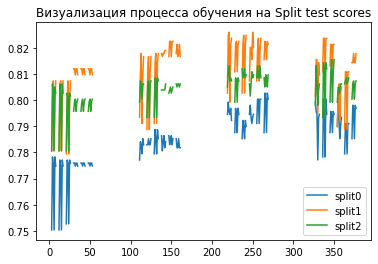

In [20]:

split0_scores = model_grid.cv_results_['split0_test_score']
split1_scores = model_grid.cv_results_['split1_test_score']
split2_scores = model_grid.cv_results_['split2_test_score']

plt.plot(split0_scores, label='split0')
plt.plot(split1_scores, label='split1')
plt.plot(split2_scores, label='split2')
plt.title('Визуализация процесса обучения на Split test scores')
plt.legend(loc='best')
plt.show()

## Проверьте модель на тестовой выборке

Теперь проверим сохраняет ли качество наша выбранная модель RandomForestClassifier с лучшими гиперпараметрами на тестовой выборке. 

In [21]:
rf = RandomForestClassifier(**model_random.best_params_)
rf.fit(features_train, target_train)
target_pred = rf.predict(features_test)
print('Accuracy RandomForestClassifier на тестовой выборке:', accuracy_score(target_test, target_pred))

Accuracy RandomForestClassifier на тестовой выборке: 0.8164852255054432


****Вывод****

Качество модели RandomForestClassifier на тестовой выборке немного меньше, но значительно не страдает 

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       446
           1       0.82      0.51      0.63       197

    accuracy                           0.82       643
   macro avg       0.82      0.73      0.75       643
weighted avg       0.82      0.82      0.80       643

confusion_matrix
[[424  22]
 [ 96 101]]


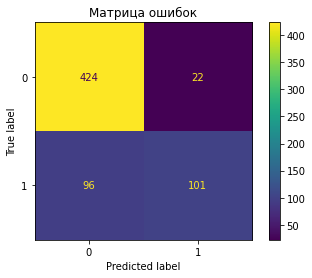

In [22]:
from sklearn. metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

report = classification_report(target_test, rf.predict(features_test))#, target_names=['Non-churned', 'Churned'])
print(report)


print("confusion_matrix")
print(confusion_matrix(target_test, target_pred))

cm = confusion_matrix(target_test, target_pred)
ConfusionMatrixDisplay(cm).plot();
plt.title("Матрица ошибок");


    
**Precision(точность)**: Процент правильных положительных прогнозов по отношению к общему количеству положительных прогнозов.

**Recall(отзыв)** : процент правильных положительных прогнозов по отношению к общему количеству фактических положительных результатов.

**F1-score(Оценка F1)** : средневзвешенное гармоническое значение точности и полноты. Чем ближе к 1, тем лучше модель.

**Support** : эти значения просто говорят нам, сколько контрактов соответствует каждому классу в тестовом наборе данных. Мы видим, что контрактов на тарифе Ultra 196, а на тарифе Smart 447

**Confusion matrix(Матрица ошибок)** – это показатель успешности классификации, где классов два или более. Это таблица с 4 различными комбинациями сочетаний прогнозируемых и фактических значений. Значения 425(тариф Smart реально Smart) и 98(Тариф Ultra реально Ultra) верно предсказаны моделью, а значения 99 (предсказанный тариф Smart в реальности Ultra) и 21 (предсказанный тариф Ultra в реальности тариф Smart) ошибочно пердсказаны моделью.



## (бонус) Проверьте модели на адекватность

Для проверки нашей модели на адекватность создадим  простейшую (dummy) модель, которая всегда предсказывает наиболее часто встречающийся класс. Так мы получим контрольные данные для сравнительной оценки построенной нами более сложной модели. К тому же мы сможем быть уверены в качестве ее работы, например, в том, что она выдает не просто набор случайно подобранных данных.

In [23]:
model_dc = DummyClassifier(strategy='most_frequent', random_state=12345)#создаем простейшую модель
model_dc.fit(features_train, target_train)#обучаем модель на тренировочных данных
result_dc = model_dc.score(features_valid, target_valid)#получаем результат на проверочных данных
print('Accuracy DummyClassifier:', result_dc)

Accuracy DummyClassifier: 0.6936236391912908


Вывод

Качество модели RandomForestClassifier гораздо выше чем простейшей модели Dummy, это означает, что наша модель вполне вменяема и эффективна.

## Общий вывод
- Исходные данные предобработанны заранее,выглядят без проблем, единственное, что в ходе в ходе изучения был заменен тип столбцов "calls" и "messages" на целочисленный;

- Были исследованы модели DecisionTreeClassifier, RandomForestClassifier и LogisticRegression;

- Предварительно наилучшую точность показала модель RandomForestClassifier, после чего, для улучшения модели, были отобрана комбинация гиперпараметров методом RandomizedSearchCV;

- Модель RandomForestClassifier с наилучшими гиперапараметрами была проверена на тестовой выборке и не показала ухудшения качества;

- Модель RandomForestClassifier проверенная на тестовой выборке была проверена на адекватность.Для сравнения использовалась простейшая модель DummyClassifier, которая показала результат Accuracy хуже, в следствие чего построенная модель случайного леса признана адекватной и эффективной. 

- В соответсвии с поставленной задачей Accuracy не ниже 0,75 достичь удалось